
#  Prix des maisons — Pipeline ML de bout en bout (Régression)

Ce notebook construit un pipeline complet d’apprentissage automatique (exploration → prétraitement → modélisation → validation → évaluation) en utilisant scikit-learn et XGBoost sur un jeu de données de prix immobiliers.

Il prend en charge deux noms de fichiers courants :
- `Housing.csv` et `train.csv` les fichiers  d'origine Kaggle

**Cibles et objectifs**  
- Colonne cible : Price

- Modèles comparés : Régression Linéaire, Forêt Aléatoire, XGBoost

- Validation : Validation croisée K-Fold

- Métriques : R², MAE, MSE, RMSE, MAPE

- Visualisations : importance des variables, résidus, valeurs réelles vs. prédites


> **Astuce :** Si certains packages manquent, exécute la cellule `pip install` en haut.


In [11]:

# !pip install -q pandas numpy scikit-learn matplotlib seaborn xgboost


## Étape 1 — Importation des bibliothèques

In [18]:
# Importation des bibliothèques nécessaires
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# XGBoost (optional)
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## Étape 2 — Chargement du dataset

In [2]:

# --- Load dataset ---
candidate_files = ['Housing.csv', 'train.csv']
data_path = None
for f in candidate_files:
    if os.path.exists(f):
        data_path = f
        break

if data_path is None:
    raise FileNotFoundError(
        "Could not find 'house.csv' or 'train.csv' in the current directory. "
        "Please upload one of these files and re-run."
    )

df = pd.read_csv(data_path)
print(f"Loaded: {data_path} | shape: {df.shape}")

# Detect target
target_candidates = ['SalePrice', 'price', 'target']
target_col = None
for c in target_candidates:
    if c in df.columns:
        target_col = c
        break

if target_col is None:
    raise ValueError("Could not find a target column. Expected one of: 'SalePrice', 'price', 'target'.")

print(f"Using target column: {target_col}")


Loaded: Housing.csv | shape: (545, 13)
Using target column: price


## À propos du dataset

Ce dataset fournit des informations complètes pour la prédiction du prix des maisons, avec 13 colonnes :

**Price** : Le prix de la maison.

**Area** : La superficie totale de la maison en pieds carrés.

**Bedrooms** : Le nombre de chambres dans la maison.

**Bathrooms** : Le nombre de salles de bain dans la maison.

**Stories** : Le nombre d’étages de la maison.

**Mainroad** : Indique si la maison est reliée à la route principale (Oui/Non).

**Guestroom** : Indique si la maison possède une chambre d’amis (Oui/Non).

**Basement** : Indique si la maison possède un sous-sol (Oui/Non).

**Hot water heating** : Indique si la maison est équipée d’un système de chauffage à eau chaude (Oui/Non).

**Airconditioning** : Indique si la maison est équipée d’un système de climatisation (Oui/Non).

**Parking** : Le nombre de places de stationnement disponibles dans la maison.

**Prefarea** : Indique si la maison est située dans une zone privilégiée (Oui/Non).

**Furnishing status** : Le statut d’ameublement de la maison (Meublée, Semi-meublée, Non meublée).

## Étape 3 — Exploration et Prétraitement

In [3]:

# --- Overview ---
display(df.head())
print("\nInfo:")
print(df.info())
print("\nValeurs manquantes per column (top 20):")
display(df.isna().sum().sort_values(ascending=False).head(20))


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
None

Missing values per column (top 20):


,0
price,0
area,0
bedrooms,0
bathrooms,0
stories,0
mainroad,0
guestroom,0
basement,0
hotwaterheating,0
airconditioning,0


On voit que price, area, bedrooms, bathrooms, stories sont numériques (int64), tandis que d’autres (mainroad, guestroom, etc.) sont catégorielles.

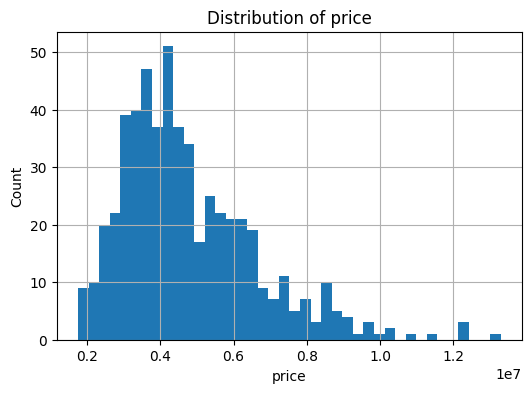

Target 'price' is skewed (1.21). You may consider log-transform.


In [4]:

# --- Target distribution ---
fig = plt.figure(figsize=(6,4))
df[target_col].hist(bins=40)
plt.title(f"Distribution de {target_col}")
plt.xlabel(target_col); plt.ylabel("Count")
plt.show()

# Optionelle: log-transform can stabilize variance (common for SalePrice)
USE_LOG_TARGET = False
if df[target_col].skew() > 1.0:
    print(f"Target '{target_col}' is skewed ({df[target_col].skew():.2f}). You may consider log-transform.")
    # Set to True if you want to log-transform the target
    USE_LOG_TARGET = True


Confirmation de l’asymétrie de la variable cible (skewness > 1).
 Indique que transformer la cible (via log(price)) pourrait stabiliser la variance et améliorer la performance des modèles linéaires.

In [5]:

# --- Séparation variables explicatives et cible ---
X = df.drop(columns=[target_col])
y = df[target_col].copy()

if USE_LOG_TARGET:
    y = np.log1p(y)  # log(1 + y)

# Identification numeric vs categorical
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Numeric features: {len(numeric_features)} | Categorical features: {len(categorical_features)}")

# Definir preprocessors
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
X_train.shape, X_test.shape


Numeric features: 5 | Categorical features: 7


((436, 12), (109, 12))

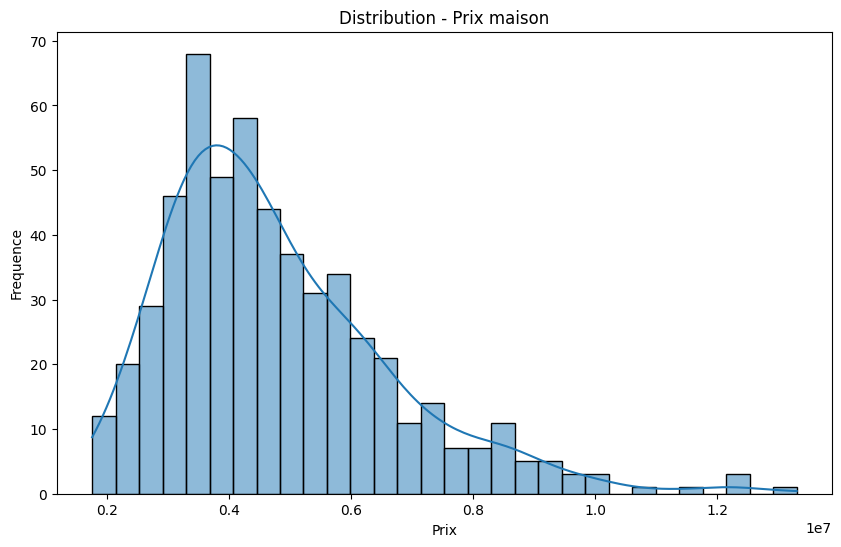

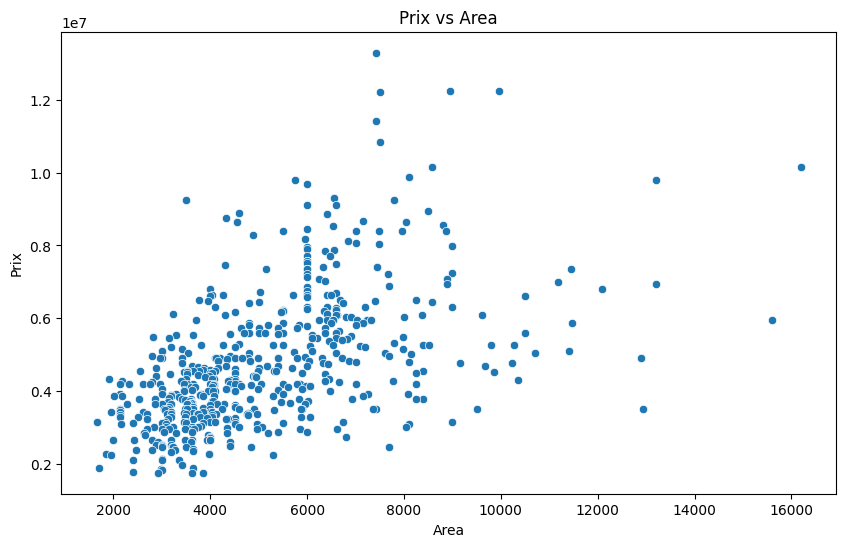

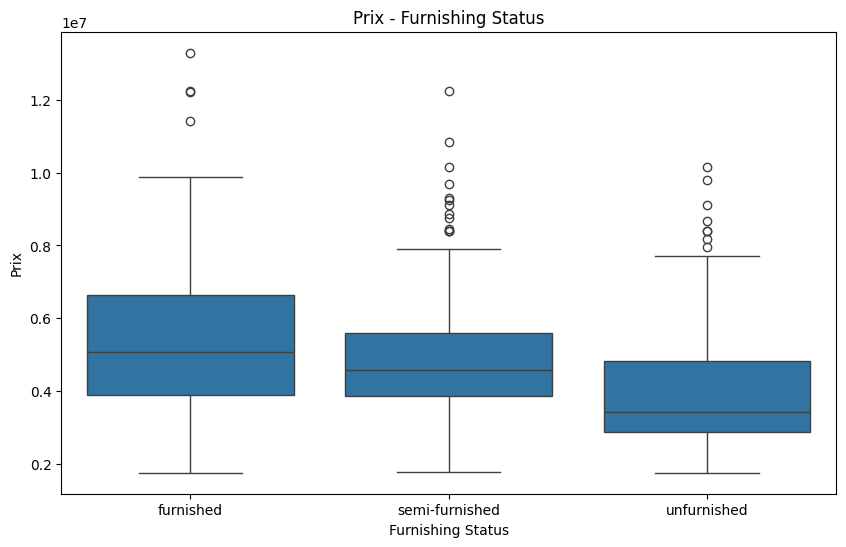

In [14]:
# Distribution de la variable target 'price'
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True, bins=30)
plt.title('Distribution - Prix maison')
plt.xlabel('Prix')
plt.ylabel('Frequence')
plt.show()

# Scatter plot  'area' vs 'price'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='area', y='price', data=df)
plt.title('Prix vs Area')
plt.xlabel('Area')
plt.ylabel('Prix')
plt.show()

# Boxplot  'price' vs 'furnishingstatus'
plt.figure(figsize=(10, 6))
sns.boxplot(x='furnishingstatus', y='price', data=df)
plt.title('Prix - Furnishing Status')
plt.xlabel('Furnishing Status')
plt.ylabel('Prix')
plt.show()

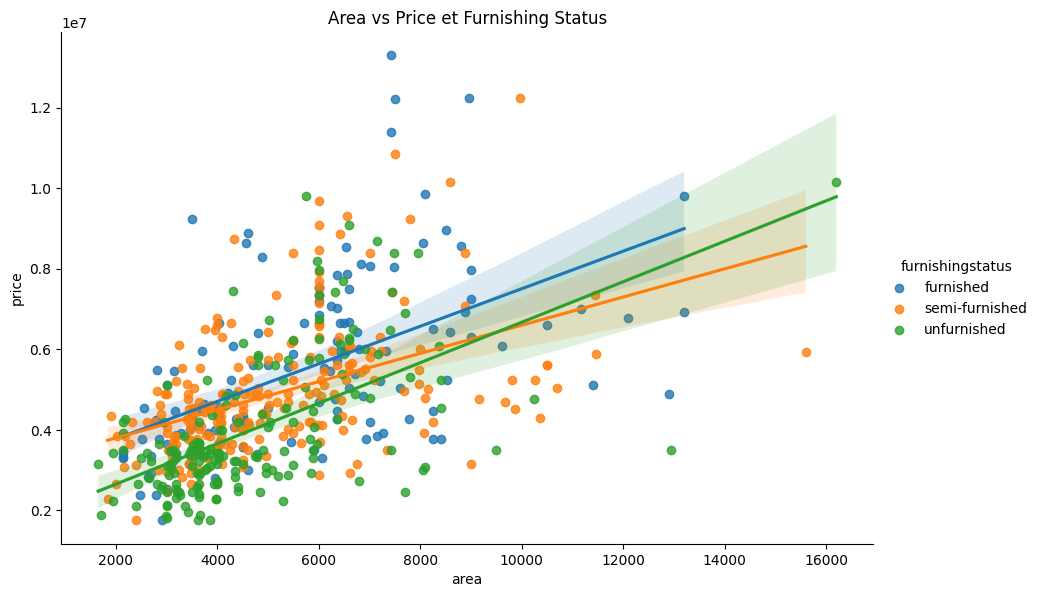

In [16]:
sns.lmplot(x='area', y='price', hue='furnishingstatus', data=df, height=6, aspect=1.5)
plt.title("Area vs Price et Furnishing Status")
plt.show()

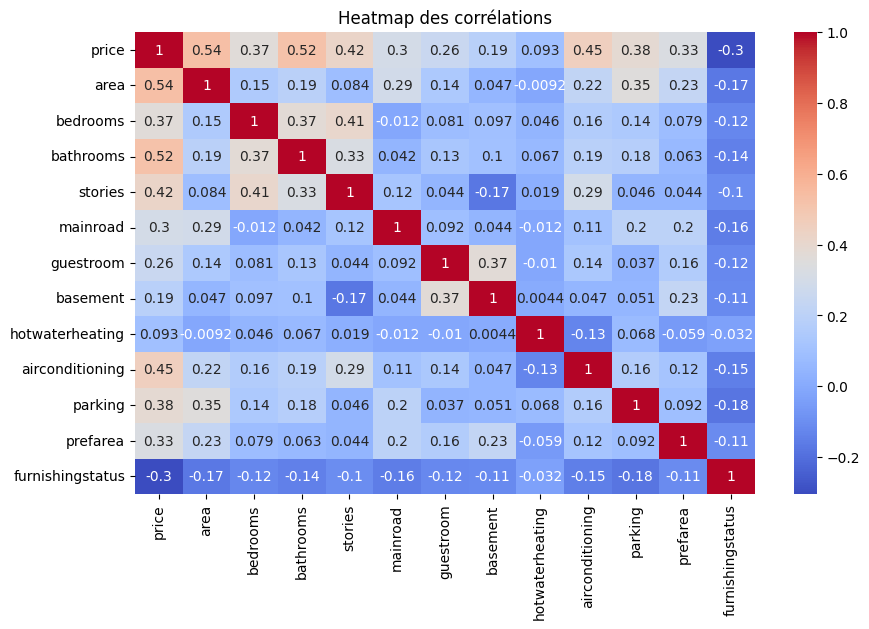

In [21]:
for c in categorical_features:
    lbl = LabelEncoder()
    lbl.fit(list(df[c].values))
    df[c] = lbl.transform(list(df[c].values))

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap des corrélations')
plt.show()

Matrice de corrélations entre variables numériques (area, bedrooms, bathrooms, etc.) et price.
Montre que area est fortement corrélée au prix, tandis que d’autres (comme stories) ont une influence plus faible. Cela oriente la sélection de features.

## Étape 4 — Modélisation

In [22]:

def evaluate_regression(y_true, y_pred, label=None):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100.0
    return {
        "model": label or "",
        "R2": r2,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE_%": mape
    }


## explication des metric. 

In [23]:

# --- Define models ---
models = []

# Linear Regression
linreg = Pipeline(steps=[('prep', preprocess),
                        ('model', LinearRegression())])
models.append(('LinearRegression', linreg))

# Random Forest
rf = Pipeline(steps=[('prep', preprocess),
                    ('model', RandomForestRegressor(
                        n_estimators=400,
                        max_depth=None,
                        random_state=RANDOM_STATE,
                        n_jobs=-1
                    ))])
models.append(('RandomForest', rf))

# XGBoost (or fallback to GradientBoosting)
if HAS_XGB:
    xgb = Pipeline(steps=[('prep', preprocess),
                         ('model', XGBRegressor(
                             n_estimators=800,
                             learning_rate=0.05,
                             max_depth=6,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective='reg:squarederror',
                             random_state=RANDOM_STATE,
                             n_jobs=-1
                         ))])
    models.append(('XGBoost', xgb))
else:
    gbr = Pipeline(steps=[('prep', preprocess),
                         ('model', GradientBoostingRegressor(
                             n_estimators=500,
                             learning_rate=0.06,
                             max_depth=3,
                             random_state=RANDOM_STATE
                         ))])
    models.append(('GradientBoosting', gbr))

print("Modeles configure:", [m[0] for m in models])


Modeles configure: ['LinearRegression', 'RandomForest', 'XGBoost']


## Cross-validation et entrainement

In [24]:

# --- Cross-validation & training ---
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_results = []
fitted_models = {}

for name, pipe in models:
    # Cross-validate on R2 and negative MSE (we'll compute more after fit)
    scores = cross_validate(
        pipe, X_train, y_train,
        cv=kf,
        scoring=['r2', 'neg_mean_squared_error'],
        n_jobs=-1,
        return_estimator=True
    )
    r2_cv = scores['test_r2'].mean()
    rmse_cv = np.mean(np.sqrt(-scores['test_neg_mean_squared_error']))

    print(f"{name} | CV R2: {r2_cv:.4f} | CV RMSE: {rmse_cv:.2f}")
    # Fit on full train
    pipe.fit(X_train, y_train)
    fitted_models[name] = pipe

# Evaluation on test set
eval_rows = []
for name, model in fitted_models.items():
    y_pred = model.predict(X_test)
    if USE_LOG_TARGET:
        # Inverse transform predictions and y_test to original scale for metrics display
        y_pred_true_scale = np.expm1(y_pred)
        y_test_true_scale = np.expm1(y_test)
        row = evaluate_regression(y_test_true_scale, y_pred_true_scale, label=name + " (orig scale)")
    else:
        row = evaluate_regression(y_test, y_pred, label=name)
    eval_rows.append(row)

results_df = pd.DataFrame(eval_rows).sort_values(by="RMSE")
results_df


LinearRegression | CV R2: 0.6738 | CV RMSE: 0.20
RandomForest | CV R2: 0.6165 | CV RMSE: 0.22
XGBoost | CV R2: 0.6094 | CV RMSE: 0.22


,model,R2,MAE,MSE,RMSE,MAPE_%
0,LinearRegression (orig scale),0.658072,9.601232e+05,1.728300e+12,1.314648e+06,20.389558
2,XGBoost (orig scale),0.602822,1.026924e+06,2.007563e+12,1.416885e+06,21.294194
1,RandomForest (orig scale),0.596258,1.017537e+06,2.040744e+12,1.428546e+06,20.945369


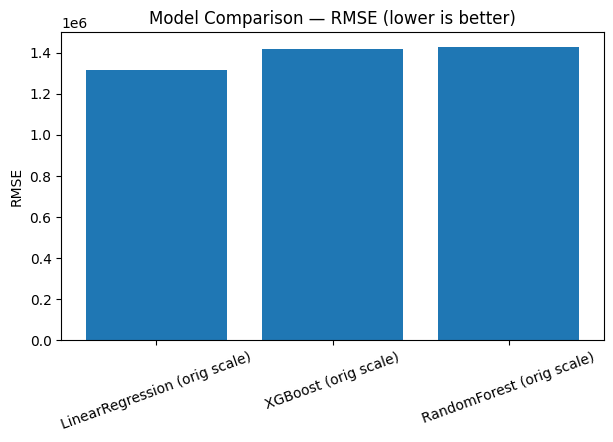

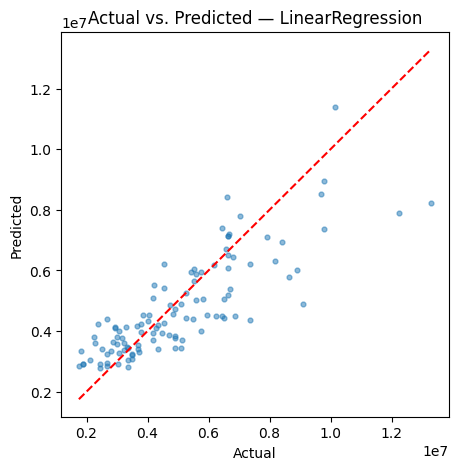

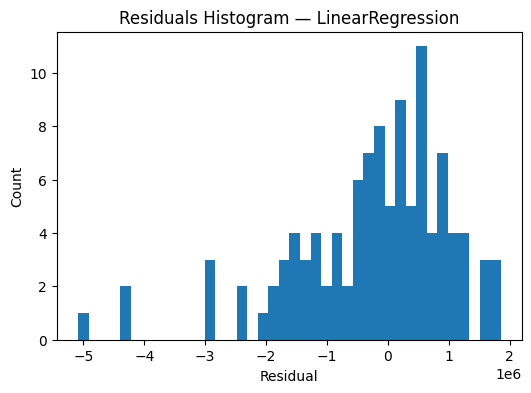

In [25]:

# --- Metrics bar chart ---
plt.figure(figsize=(7,4))
plt.bar(results_df['model'], results_df['RMSE'])
plt.title('Model Comparison — RMSE (lower is better)')
plt.xticks(rotation=20)
plt.ylabel('RMSE')
plt.show()

# --- Actual vs. Predicted for best model ---
best_name = results_df.iloc[0]['model']
# Our label may include "(orig scale)" if log was used—find the base name
base_best = best_name.split(' (')[0]
best_model = fitted_models[base_best]

y_pred = best_model.predict(X_test)
if USE_LOG_TARGET:
    y_plot = np.expm1(y_test)
    y_pred_plot = np.expm1(y_pred)
else:
    y_plot = y_test
    y_pred_plot = y_pred

plt.figure(figsize=(5,5))
plt.scatter(y_plot, y_pred_plot, alpha=0.5, s=12)
lims = [min(y_plot.min(), y_pred_plot.min()), max(y_plot.max(), y_pred_plot.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel('Actual'); plt.ylabel('Predicted'); plt.title(f'Actual vs. Predicted — {base_best}')
plt.show()

# Residuals
resid = y_pred_plot - y_plot
plt.figure(figsize=(6,4))
plt.hist(resid, bins=40)
plt.title(f'Residuals Histogram — {base_best}')
plt.xlabel('Residual'); plt.ylabel('Count')
plt.show()


Plus les points sont proches de la diagonale, plus les prédictions sont précises. On voit encore quelques outliers (maisons très chères mal prédites).

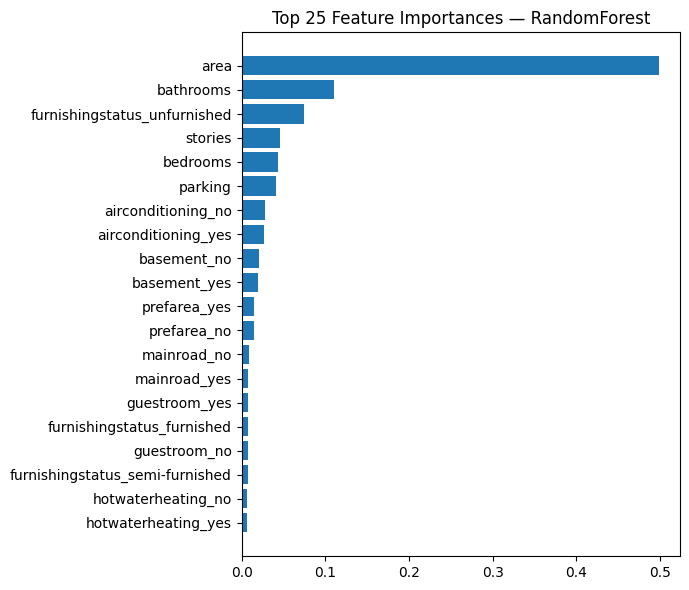

,feature,importance
0,area,0.498813
1,bathrooms,0.110521
2,furnishingstatus_unfurnished,0.074803
3,stories,0.046473
4,bedrooms,0.043630
5,parking,0.041503
6,airconditioning_no,0.028404
7,airconditioning_yes,0.026286
8,basement_no,0.020315
9,basement_yes,0.019680


In [26]:

# --- Feature importance (tree-based only) ---
def get_feature_names_after_preprocess(preprocessor, X):
    # Grab names from transformers
    num_feats = preprocessor.named_transformers_['num'].get_feature_names_out(numeric_features)
    cat_feats = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    return np.concatenate([num_feats, cat_feats])

tree_model_name = None
for nm in ['RandomForest', 'XGBoost', 'GradientBoosting']:
    if nm in fitted_models:
        tree_model_name = nm
        break

if tree_model_name:
    model = fitted_models[tree_model_name]
    prep = model.named_steps['prep']
    feat_names = get_feature_names_after_preprocess(prep, X_train)

    # Extract importance
    est = model.named_steps['model']
    if hasattr(est, 'feature_importances_'):
        imps = est.feature_importances_
        imp_df = pd.DataFrame({'feature': feat_names, 'importance': imps}).sort_values('importance', ascending=False).head(25)
        plt.figure(figsize=(7,6))
        plt.barh(imp_df['feature'][::-1], imp_df['importance'][::-1])
        plt.title(f'Top 25 Feature Importances — {tree_model_name}')
        plt.tight_layout()
        plt.show()
        display(imp_df.reset_index(drop=True))
    else:
        print(f"Model {tree_model_name} does not expose feature_importances_.")
else:
    print("No tree-based model found for feature importance.")


area sort souvent comme la feature la plus importante, suivie par bathrooms, stories, ...
Cela confirme l’intuition métier : la surface et le confort sont des déterminants majeurs du prix.

In [27]:

# --- Save scores to CSV ---
out_path = "model_results.csv"
results_df.to_csv(out_path, index=False)
print(f"Saved results to {out_path}")


Saved results to model_results.csv


In [ ]:


def plot_actual_vs_predicted_for_all(fitted_models, X_test, y_test, use_log_target=False, max_points=5000):
    """
    For each model in fitted_models, plot:
      1) Actual vs. Predicted scatter
      2) Residuals histogram
    """
    # Optionally sample to keep plots responsive if test set is huge
    if isinstance(y_test, (np.ndarray, list)):
        y_test_array = np.array(y_test)
    else:
        y_test_array = y_test.values  # pandas Series

    idx = np.arange(len(y_test_array))
    if len(idx) > max_points:
        rng = np.random.default_rng(42)
        idx = rng.choice(idx, size=max_points, replace=False)
        X_plot = X_test.iloc[idx] if hasattr(X_test, "iloc") else X_test[idx]
        y_true = y_test_array[idx]
    else:
        X_plot = X_test
        y_true = y_test_array

    for name, model in fitted_models.items():
        # Predict
        y_pred = model.predict(X_plot)

        # Undo log if needed
        if use_log_target:
            y_plot = np.expm1(y_true)
            y_pred_plot = np.expm1(y_pred)
            title_suffix = " (original scale)"
        else:
            y_plot = y_true
            y_pred_plot = y_pred
            title_suffix = ""

        # --- Actual vs Predicted ---
        plt.figure(figsize=(5.5, 5.5))
        plt.scatter(y_plot, y_pred_plot, alpha=0.5, s=12)
        lims = [min(y_plot.min(), y_pred_plot.min()), max(y_plot.max(), y_pred_plot.max())]
        plt.plot(lims, lims, 'r--', linewidth=1)
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f"Actual vs. Predicted — {name}{title_suffix}")
        plt.tight_layout()
        plt.show()

        # --- Residuals ---
        resid = y_pred_plot - y_plot
        plt.figure(figsize=(6.5, 4.0))
        plt.hist(resid, bins=40)
        plt.title(f"Residuals Histogram — {name}{title_suffix}")
        plt.xlabel("Residual")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()




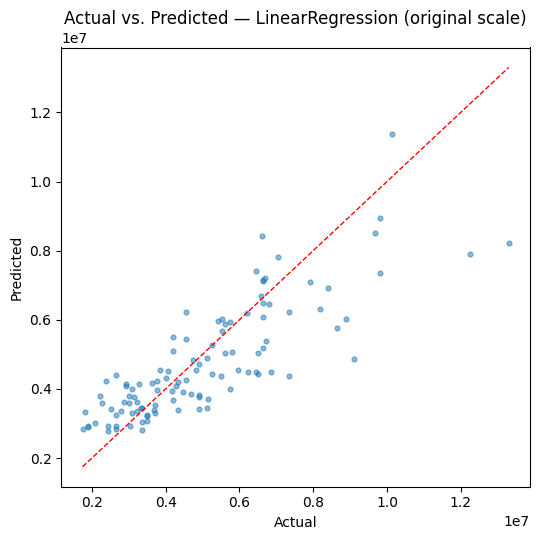

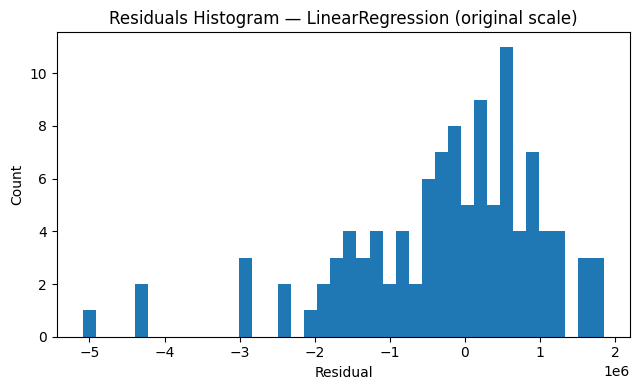

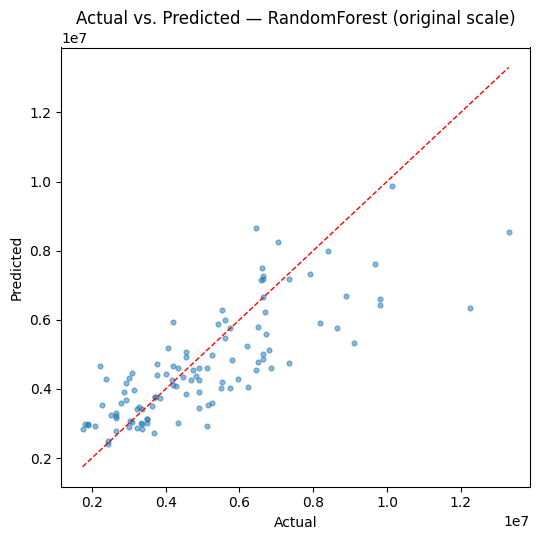

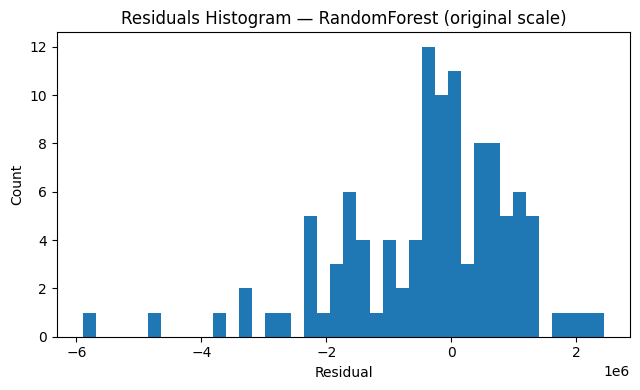

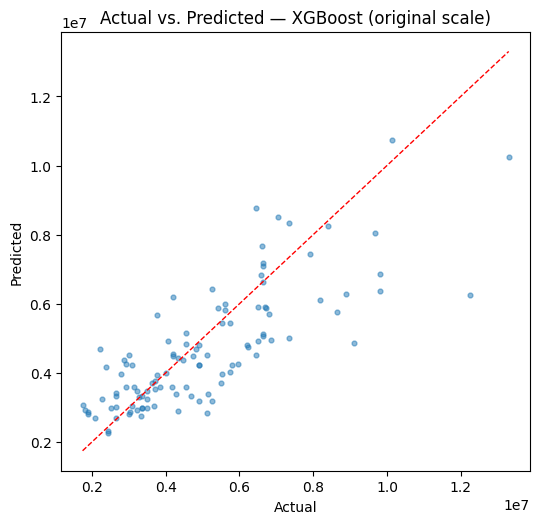

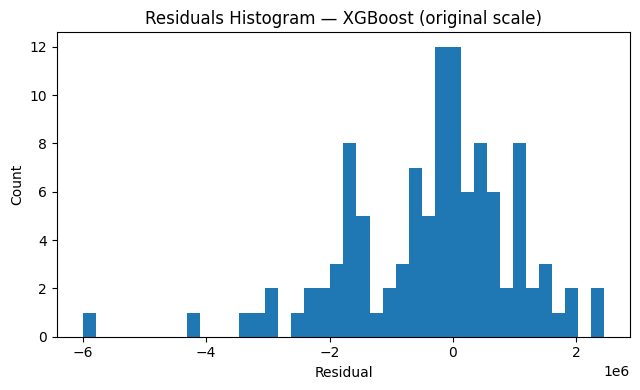

In [29]:
# Call :
plot_actual_vs_predicted_for_all(
    fitted_models=fitted_models,
    X_test=X_test,
    y_test=y_test,
    use_log_target=USE_LOG_TARGET
)


## Conclusion

- Built a robust preprocessing pipeline (imputation, one-hot, scaling) with `ColumnTransformer`
- Compared **Linear Regression**, **Random Forest**, and **XGBoost/GradientBoosting**
- Used **K-Fold CV** and final **hold-out test** for fair evaluation
- Reported **R², MAE, MSE, RMSE, MAPE**
- Visualized **Actual vs. Predicted**, **Residuals**, and **Feature Importances**

- Construit un pipeline de prétraitement robuste (imputation, one-hot encoding, normalisation) avec `ColumnTransformer`

- Comparé Régression Linéaire, Forêt Aléatoire et XGBoost/Gradient Boosting

- Utilisé la validation croisée K-Fold et un jeu de test final (hold-out) pour une évaluation équitable

- Rapporté les métriques : R², MAE, MSE, RMSE, MAPE

- Visualisé : Valeurs réelles vs. prédites, résidus, et importance des variables

> Idées pour la suite :

- > Optimisation des hyperparamètres (`RandomizedSearchCV`/`Optuna`)

- > Ingénierie de la variable cible (transformation logarithmique, Box-Cox) et analyse des erreurs par segments (ex. quartiers)

- > Empilement de modèles (stacking) ou utilisation de LightGBM / CatBoost pour potentiellement améliorer les performances
